# Introduction

**We will Predict sales for the thousands of product families sold at Favorita stores located in Ecuador. The training data includes dates, store and product information, whether that item was being promoted, as well as the sales numbers. Additional files include supplementary information that may be useful in building your models.**

File Descriptions and Data Field Information

1.   **train.csv**
The training data, comprising time series of features store_nbr, family, and onpromotion as well as the target sales.
store_nbr identifies the store at which the products are sold.
family identifies the type of product sold.
sales gives the total sales for a product family at a particular store at a given date. Fractional values are possible since products can be sold in fractional units (1.5 kg of cheese, for instance, as opposed to 1 bag of chips).
onpromotion gives the total number of items in a product family that were being promoted at a store at a given date.

2.   **test.csv**
The test data, having the same features as the training data. You will predict the target sales for the dates in this file.
The dates in the test data are for the 15 days after the last date in the training data.
sample_submission.csv
A sample submission file in the correct format.
3.  **stores.csv**
Store metadata, including city, state, type, and cluster.
cluster is a grouping of similar stores.

4. **oil.csv**
Daily oil price. Includes values during both the train and test data timeframes. (Ecuador is an oil-dependent country and it's economical health is highly vulnerable to shocks in oil prices.)
5.  **holidays_events.csv**
Holidays and Events, with metadata
NOTE: Pay special attention to the transferred column. A holiday that is transferred officially falls on that calendar day, but was moved to another date by the government. A transferred day is more like a normal day than a holiday. To find the day that it was actually celebrated, look for the corresponding row where type is Transfer. For example, the holiday Independencia de Guayaquil was transferred from 2012-10-09 to 2012-10-12, which means it was celebrated on 2012-10-12. Days that are type Bridge are extra days that are added to a holiday (e.g., to extend the break across a long weekend). These are frequently made up by the type Work Day which is a day not normally scheduled for work (e.g., Saturday) that is meant to payback the Bridge.
Additional holidays are days added a regular calendar holiday, for example, as typically happens around Christmas (making Christmas Eve a holiday).


**Additional Notes**
1. Wages in the public sector are paid every two weeks on the 15 th and on the last day of the month. Supermarket sales could be affected by this.
2. A magnitude 7.8 earthquake struck Ecuador on April 16, 2016. People rallied in relief efforts donating water and other first need products which greatly affected supermarket sales for several weeks after the earthquake.

# Initial Installations and setup

In [1]:
%load_ext cudf.pandas

In [2]:
!pip install cuml-cu12==24.10.*

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Installing build dependencies ... done
  Getting requ

In [3]:
!gdown 1seOAJxGY0MxdR90-emKqGFY0ejUcp8tn
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Downloading...
From: https://drive.google.com/uc?id=1seOAJxGY0MxdR90-emKqGFY0ejUcp8tn
To: /content/kaggle.json
100% 69.0/69.0 [00:00<00:00, 263kB/s]


In [4]:
!kaggle competitions download -c store-sales-time-series-forecasting

 23% 5.00M/21.4M [00:00<00:00, 31.5MB/s]
100% 21.4M/21.4M [00:00<00:00, 95.5MB/s]


In [5]:
!unzip store-sales-time-series-forecasting

Archive:  store-sales-time-series-forecasting.zip
  inflating: holidays_events.csv     
  inflating: oil.csv                 
  inflating: sample_submission.csv   
  inflating: stores.csv              
  inflating: test.csv                
  inflating: train.csv               
  inflating: transactions.csv        


# Load and Inspect the Datasets

In [6]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [7]:
import cuml
from cuml.preprocessing import LabelEncoder, StandardScaler
from cuml.metrics import mean_squared_error, mean_absolute_error
from cuml.model_selection import train_test_split
from cuml.ensemble import RandomForestRegressor
import cupy as cp
# from sklearn.metrics import mean_squared_error, mean_absolute_error
# from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.ensemble import GradientBoostingRegressor

from sklearn.impute import SimpleImputer

import xgboost as xgb

import warnings
warnings.filterwarnings('ignore')

In [8]:
df_train = pd.read_csv('train.csv', parse_dates=['date'], index_col='id')
df_train.tail()

,date,store_nbr,family,sales,onpromotion
id,,,,,
3000883,2017-08-15,9,POULTRY,438.133,0
3000884,2017-08-15,9,PREPARED FOODS,154.553,1
3000885,2017-08-15,9,PRODUCE,2419.729,148
3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.000,8
3000887,2017-08-15,9,SEAFOOD,16.000,0


In [9]:
store_sales = df_train.copy()
store_sales = store_sales.set_index('date').to_period('D')
store_sales = store_sales.set_index(['store_nbr', 'family'], append=True)

In [10]:
store_sales

sales  onpromotion
date       store_nbr family                                           
2013-01-01 1         AUTOMOTIVE                     0.000            0
                     BABY CARE                      0.000            0
                     BEAUTY                         0.000            0
                     BEVERAGES                      0.000            0
                     BOOKS                          0.000            0
...                                                   ...          ...
2017-08-15 9         POULTRY                      438.133            0
                     PREPARED FOODS               154.553            1
                     PRODUCE                     2419.729          148
                     SCHOOL AND OFFICE SUPPLIES   121.000            8
                     SEAFOOD                       16.000            0

[3000888 rows x 2 columns]

In [11]:
average_sales = store_sales.groupby('date').mean()['sales']
average_sales

,sales
date,
2013-01-01,1.409438
2013-01-02,278.390807
2013-01-03,202.840197
2013-01-04,198.911154
2013-01-05,267.873244
...,...
2017-08-11,463.733851
2017-08-12,444.798280
2017-08-13,485.768618


In [12]:
df_store = pd.read_csv('stores.csv', index_col="store_nbr")
df_store = df_store.rename(columns={'type': 'store_type'})
df_store.tail()

,city,state,store_type,cluster
store_nbr,,,,
50,Ambato,Tungurahua,A,14
51,Guayaquil,Guayas,A,17
52,Manta,Manabi,A,11
53,Manta,Manabi,D,13
54,El Carmen,Manabi,C,3


In [13]:
df_transacion = pd.read_csv('transactions.csv',parse_dates=['date'])
df_transacion.tail()

,date,store_nbr,transactions
83483,2017-08-15,50,2804
83484,2017-08-15,51,1573
83485,2017-08-15,52,2255
83486,2017-08-15,53,932
83487,2017-08-15,54,802


In [14]:
# prompt: df_oil = pd.read_csv('oil.csv', parse_dates=['date'])
# df_oil.tail()
# Add a column called "Wage day"  whcih has value True on 15th and last date of every month

df_oil = pd.read_csv('oil.csv', parse_dates=['date'])
df_oil.tail()

,date,dcoilwtico
1213,2017-08-25,47.65
1214,2017-08-28,46.40
1215,2017-08-29,46.46
1216,2017-08-30,45.96
1217,2017-08-31,47.26


In [15]:
df_holiday_events = pd.read_csv('holidays_events.csv', parse_dates=['date'], dtype={
        'type': 'category',
        'locale': 'category',
        'locale_name': 'category',
        'description': 'category',
        'transferred': 'bool',
    })
df_holiday_events.tail()

,date,type,locale,locale_name,description,transferred
345,2017-12-22,Additional,National,Ecuador,Navidad-3,False
346,2017-12-23,Additional,National,Ecuador,Navidad-2,False
347,2017-12-24,Additional,National,Ecuador,Navidad-1,False
348,2017-12-25,Holiday,National,Ecuador,Navidad,False
349,2017-12-26,Additional,National,Ecuador,Navidad+1,False


In [16]:
df_test = pd.read_csv('test.csv', parse_dates=['date'], index_col='id')
df_test.tail()

,date,store_nbr,family,onpromotion
id,,,,
3029395,2017-08-31,9,POULTRY,1
3029396,2017-08-31,9,PREPARED FOODS,0
3029397,2017-08-31,9,PRODUCE,1
3029398,2017-08-31,9,SCHOOL AND OFFICE SUPPLIES,9
3029399,2017-08-31,9,SEAFOOD,0


In [17]:
# !mkdir df_descriptions
# df_train.describe().to_csv('df_descriptions/train_describe.csv')
# df_oil.describe().to_csv('df_descriptions/oil_describe.csv')
# df_holiday_events.describe().to_csv('df_descriptions/holiday_describe.csv')
# df_store.describe().to_csv('df_descriptions/store_describe.csv')
# df_transacion.describe().to_csv('df_descriptions/transaction_describe.csv')

In [18]:
def mergeDataSetWithOtherDataSets(df):
  # Merge train data with stores data on 'store_nbr'
  df = df.merge(df_store, on='store_nbr', how='left')
  # Merge train_merged with oil data on 'date'
  df = df.merge(df_oil, on='date', how='left')
  # Merge train_merged with holidays data on 'date'
  df = df.merge(df_holiday_events, on='date', how='left')
  # Merge train_merged with transactions data on 'date' and 'store_nbr'
  df = df.merge(df_transacion, on=['date', 'store_nbr'], how='left')
  return df

In [19]:
train_merged = mergeDataSetWithOtherDataSets(df_train)

In [20]:
train_merged

,date,store_nbr,family,sales,onpromotion,city,state,store_type,cluster,dcoilwtico,type,locale,locale_name,description,transferred,transactions
0,2013-01-01,1,AUTOMOTIVE,0.000,0,Quito,Pichincha,D,13,<NA>,Holiday,National,Ecuador,Primer dia del ano,False,<NA>
1,2013-01-01,1,BABY CARE,0.000,0,Quito,Pichincha,D,13,<NA>,Holiday,National,Ecuador,Primer dia del ano,False,<NA>
2,2013-01-01,1,BEAUTY,0.000,0,Quito,Pichincha,D,13,<NA>,Holiday,National,Ecuador,Primer dia del ano,False,<NA>
3,2013-01-01,1,BEVERAGES,0.000,0,Quito,Pichincha,D,13,<NA>,Holiday,National,Ecuador,Primer dia del ano,False,<NA>
4,2013-01-01,1,BOOKS,0.000,0,Quito,Pichincha,D,13,<NA>,Holiday,National,Ecuador,Primer dia del ano,False,<NA>
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3054343,2017-08-15,9,POULTRY,438.133,0,Quito,Pichincha,B,6,47.57,Holiday,Local,Riobamba,Fundacion de Riobamba,False,2155
3054344,2017-08-15,9,PREPARED FOODS,154.553,1,Quito,Pichincha,B,6,47.57,Holiday,Local,Riobamba,Fundacion de Riobamba,False,2155
3054345,2017-08-15,9,PRODUCE,2419.729,148,Quito,Pichincha,B,6,47.57,Holiday,Local,Riobamba,Fundacion de Riobamba,False,2155
3054346,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.000,8,Quito,Pichincha,B,6,47.57,Holiday,Local,Riobamba,Fundacion de Riobamba,False,2155


In [21]:
train_merged.info()

<class 'cudf.core.dataframe.DataFrame'>
RangeIndex: 3054348 entries, 0 to 3054347
Data columns (total 16 columns):
 #   Column        Dtype
---  ------        -----
 0   date          datetime64[ns]
 1   store_nbr     int64
 2   family        object
 3   sales         float64
 4   onpromotion   int64
 5   city          object
 6   state         object
 7   store_type    object
 8   cluster       int64
 9   dcoilwtico    float64
 10  type          category
 11  locale        category
 12  locale_name   category
 13  description   category
 14  transferred   bool
 15  transactions  int64
dtypes: bool(1), category(4), datetime64[ns](1), float64(2), int64(4), object(4)
memory usage: 307.0+ MB


In [22]:
train_merged.describe()

,date,store_nbr,sales,onpromotion,cluster,dcoilwtico,transactions
count,3054348,3.054348e+06,3.054348e+06,3.054348e+06,3.054348e+06,2.099196e+06,2.805231e+06
mean,2015-04-26 12:11:45.717619456,2.750000e+01,3.590209e+02,2.617480e+00,8.481481e+00,6.801587e+01,1.697071e+03
min,2013-01-01 00:00:00,1.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,2.619000e+01,5.000000e+00
25%,2014-03-01 00:00:00,1.400000e+01,0.000000e+00,0.000000e+00,4.000000e+00,4.641000e+01,1.046000e+03
50%,2015-04-28 12:00:00,2.750000e+01,1.100000e+01,0.000000e+00,8.500000e+00,5.343000e+01,1.395000e+03
75%,2016-06-22 00:00:00,4.100000e+01,1.960110e+02,0.000000e+00,1.300000e+01,9.581000e+01,2.081000e+03
max,2017-08-15 00:00:00,5.400000e+01,1.247170e+05,7.410000e+02,1.700000e+01,1.106200e+02,8.359000e+03
std,<NA>,1.558579e+01,1.107286e+03,1.225494e+01,4.649735e+00,2.569134e+01,9.668317e+02


In [23]:
train_merged.isnull().sum()

,0
date,0
store_nbr,0
family,0
sales,0
onpromotion,0
city,0
state,0
store_type,0
cluster,0
dcoilwtico,955152


In [24]:
train_merged.describe().to_csv('train_merged_description.csv')

# Data Visulization

## sales over time

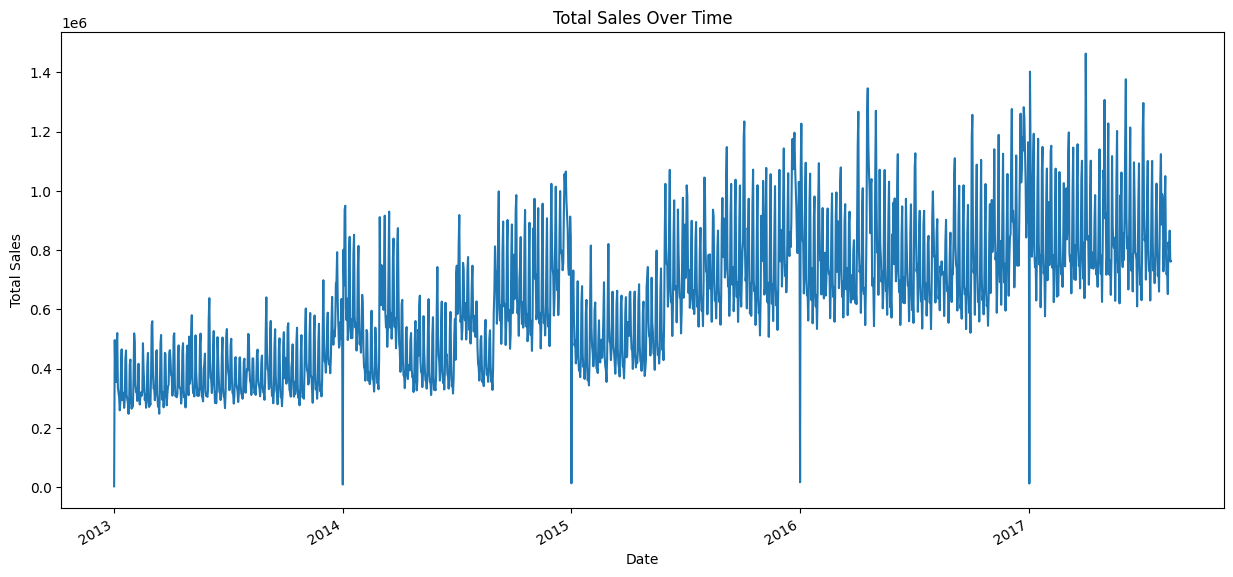

In [25]:
plt.figure(figsize=(15,7))
df_train.groupby('date')['sales'].sum().plot()
plt.title('Total Sales Over Time')
plt.xlabel('Date')
plt.ylabel('Total Sales')
plt.show()

## Sales by Store

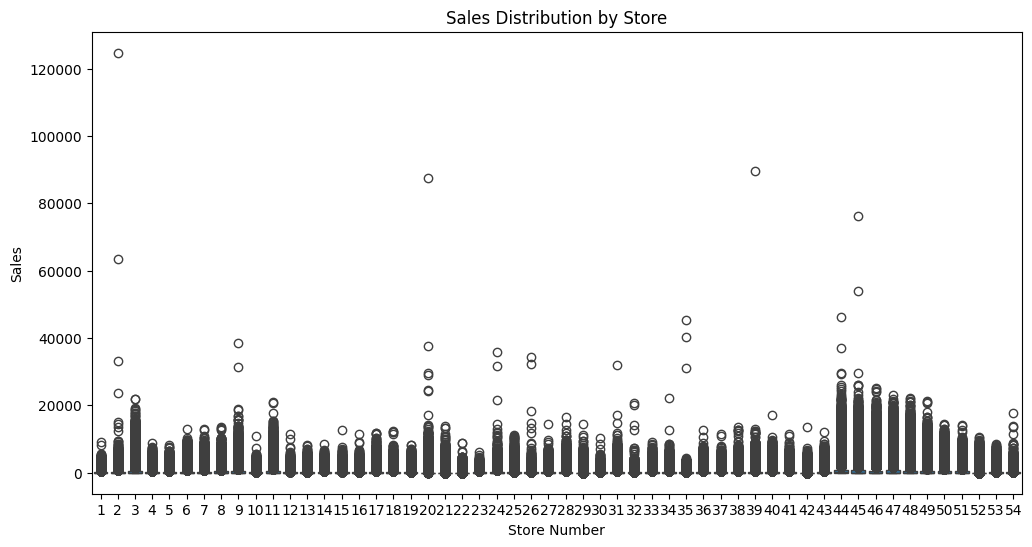

In [26]:
plt.figure(figsize=(12,6))
sns.boxplot(x='store_nbr', y='sales', data=df_train)
plt.title('Sales Distribution by Store')
plt.xlabel('Store Number')
plt.ylabel('Sales')
plt.show()

## Sales by product family

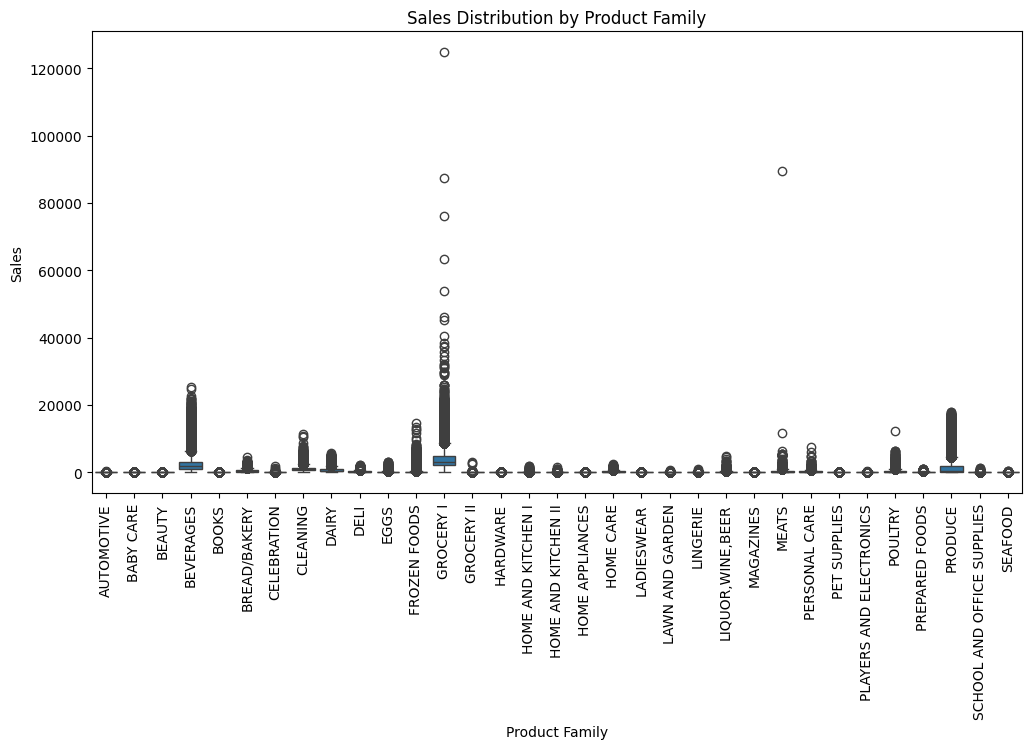

In [27]:
plt.figure(figsize=(12,6))
sns.boxplot(x='family', y='sales', data=df_train)
plt.title('Sales Distribution by Product Family')
plt.xlabel('Product Family')
plt.ylabel('Sales')
plt.xticks(rotation=90)
plt.show()

## Promotion vs Sales

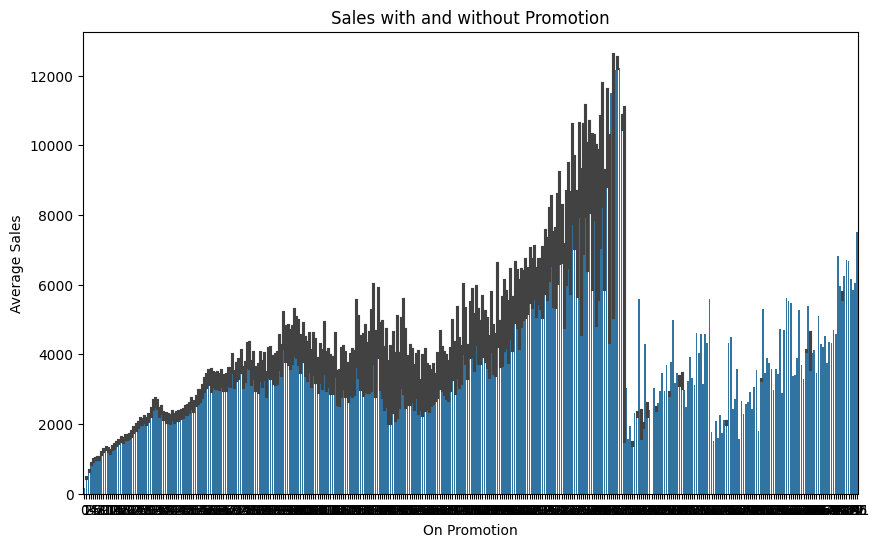

In [28]:
plt.figure(figsize=(10,6))
sns.barplot(x='onpromotion', y='sales', data=df_train)
plt.title('Sales with and without Promotion')
plt.xlabel('On Promotion')
plt.ylabel('Average Sales')
plt.show()

## Oil price over time

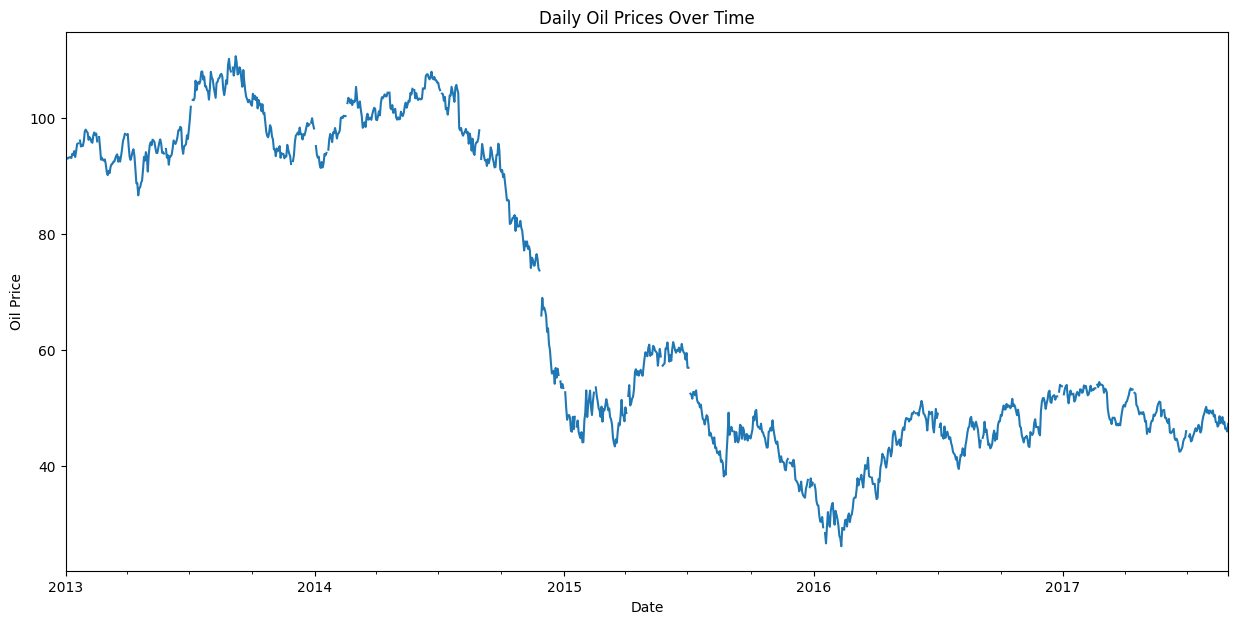

In [29]:
plt.figure(figsize=(15,7))
df_oil.set_index('date')['dcoilwtico'].plot()
plt.title('Daily Oil Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Oil Price')
plt.show()

## Transaction over time

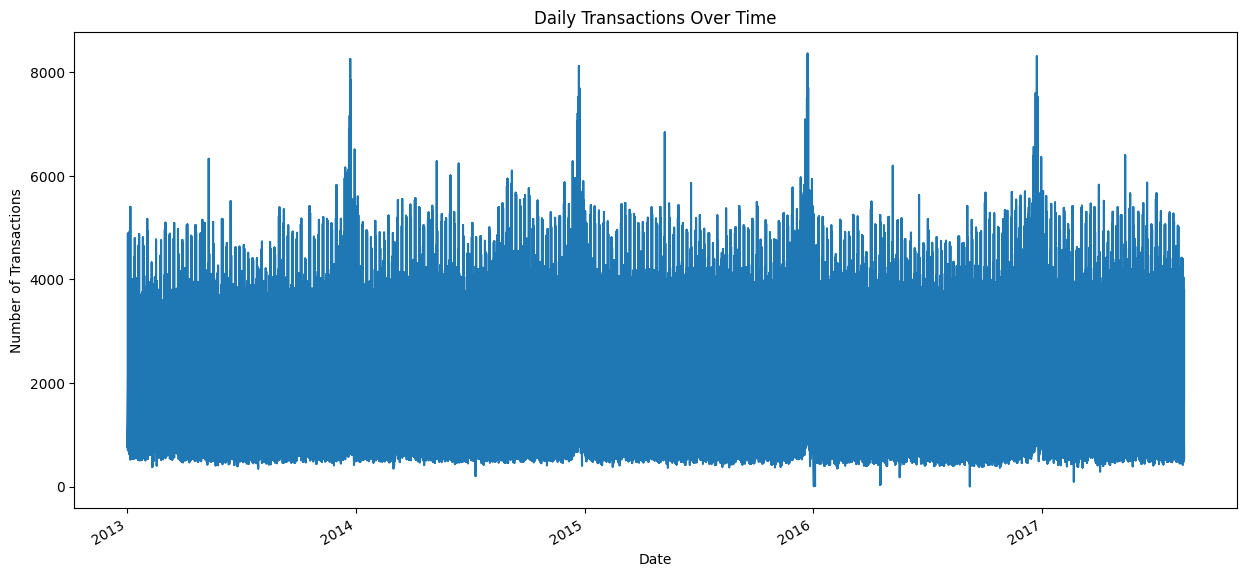

In [30]:
plt.figure(figsize=(15,7))
df_transacion.set_index('date')['transactions'].plot()
plt.title('Daily Transactions Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Transactions')
plt.show()

# Data cleaning and preprocessing

### Merge oil prices with train and test datasets

In [31]:
df_train = pd.merge(df_train, df_oil, on='date', how='left', suffixes=('', '_y'))
df_test = pd.merge(df_test, df_oil, on='date', how='left', suffixes=('', '_y'))

In [32]:
df_train.columns.tolist()

['date', 'store_nbr', 'family', 'sales', 'onpromotion', 'dcoilwtico']

In [33]:
df_test.columns.tolist()

['date', 'store_nbr', 'family', 'onpromotion', 'dcoilwtico']

In [34]:
df_train['dcoilwtico'].fillna(method='ffill', inplace=True)
df_test['dcoilwtico'].fillna(method='ffill', inplace=True)

In [35]:
# Add 'is_train' flag to distinguish between train and test after concatenation
df_train['is_train'] = 1
df_test['is_train'] = 0

# For test set, set 'sales' to NaN as it's unknown
df_test['sales'] = np.nan

## Concatenate train and test datasets


In [36]:
combined = pd.concat([df_train, df_test], sort=False)

# Sort combined data by 'store_nbr', 'family', and 'date'
combined = combined.sort_values(['store_nbr', 'family', 'date'])
combined

,date,store_nbr,family,sales,onpromotion,dcoilwtico,is_train
0,2013-01-01,1,AUTOMOTIVE,0.0,0,<NA>,1
1782,2013-01-02,1,AUTOMOTIVE,2.0,0,93.14,1
3564,2013-01-03,1,AUTOMOTIVE,3.0,0,92.97,1
5346,2013-01-04,1,AUTOMOTIVE,3.0,0,93.12,1
7128,2013-01-05,1,AUTOMOTIVE,5.0,0,93.12,1
...,...,...,...,...,...,...,...
21251,2017-08-27,54,SEAFOOD,NaN,0,47.65,0
23033,2017-08-28,54,SEAFOOD,NaN,0,46.4,0
24815,2017-08-29,54,SEAFOOD,NaN,0,46.46,0
26597,2017-08-30,54,SEAFOOD,NaN,0,45.96,0


### Adding Wage_Day

In [37]:
# Create a new column "Wage day" with initial value False
combined['Wage_day'] = False

# Find the 15th and last day of each month and set "Wage day" to True for those dates
for year in combined['date'].dt.year.unique():
  for month in combined['date'].dt.month.unique():
    # 15th day of the month
    day15 = pd.Timestamp(year=year, month=month, day=15)
    if day15 in combined['date'].values:
      combined.loc[combined['date'] == day15, 'Wage_day'] = True

    # Last day of the month
    last_day = pd.Timestamp(year=year, month=month, day=1) + pd.offsets.MonthEnd(0)
    if last_day in combined['date'].values:
      combined.loc[combined['date'] == last_day, 'Wage_day'] = True

combined.columns.tolist()

['date',
 'store_nbr',
 'family',
 'sales',
 'onpromotion',
 'dcoilwtico',
 'is_train',
 'Wage_day']

### Merge transactions with combined dataset


In [38]:
combined = pd.merge(combined, df_transacion, on=['store_nbr', 'date'], how='left')

# Fill missing 'transactions' with median from training set
median_transactions = combined[combined['is_train'] == 1]['transactions'].median()
combined['transactions'].fillna(median_transactions, inplace=True)


## Create lag features

In [39]:
combined['sales_lag_1'] = combined.groupby(['store_nbr', 'family'])['sales'].shift(1)
combined['sales_lag_7'] = combined.groupby(['store_nbr', 'family'])['sales'].shift(7)
combined['sales_roll_mean_7'] = combined.groupby(['store_nbr', 'family'])['sales'].shift(1).rolling(window=7).mean()
combined['sales_roll_std_7'] = combined.groupby(['store_nbr', 'family'])['sales'].shift(1).rolling(window=7).std()
combined['promo_last_7'] = combined.groupby(['store_nbr', 'family'])['onpromotion'].shift(1).rolling(window=7).sum()

## Fill missing values in lag features with 0

In [40]:
lag_features = ['sales_lag_1', 'sales_lag_7', 'sales_roll_mean_7', 'sales_roll_std_7']
for feature in lag_features:
    if feature in combined.columns:
        combined[feature].fillna(0, inplace=True)
        print(f"Filled missing values in '{feature}' with 0.")
    else:
        print(f"'{feature}' column not found in combined dataset.")

Filled missing values in 'sales_lag_1' with 0.
Filled missing values in 'sales_lag_7' with 0.
Filled missing values in 'sales_roll_mean_7' with 0.
Filled missing values in 'sales_roll_std_7' with 0.


In [41]:
# Fill 'promo_last_7' with 0
combined['promo_last_7'].fillna(0, inplace=True)

In [42]:
train_processed = combined[combined['is_train'] == 1].copy()
test_processed = combined[combined['is_train'] == 0].copy()

In [43]:
train_processed.drop(['is_train'], axis=1, inplace=True)
test_processed.drop(['is_train'], axis=1, inplace=True)

In [44]:
train_processed.head()

,date,store_nbr,family,sales,onpromotion,dcoilwtico,Wage_day,transactions,sales_lag_1,sales_lag_7,sales_roll_mean_7,sales_roll_std_7,promo_last_7
0,2013-01-01,1,AUTOMOTIVE,0.0,0,<NA>,False,1393,0.0,0.0,0.0,0.0,0
1,2013-01-02,1,AUTOMOTIVE,2.0,0,93.14,False,2111,0.0,0.0,0.0,0.0,0
2,2013-01-03,1,AUTOMOTIVE,3.0,0,92.97,False,1833,2.0,0.0,0.0,0.0,0
3,2013-01-04,1,AUTOMOTIVE,3.0,0,93.12,False,1863,3.0,0.0,0.0,0.0,0
4,2013-01-05,1,AUTOMOTIVE,5.0,0,93.12,False,1509,3.0,0.0,0.0,0.0,0


In [45]:
test_processed.head()

,date,store_nbr,family,sales,onpromotion,dcoilwtico,Wage_day,transactions,sales_lag_1,sales_lag_7,sales_roll_mean_7,sales_roll_std_7,promo_last_7
1684,2017-08-16,1,AUTOMOTIVE,NaN,0,46.80,False,1393,4.0,7.0,4.142857,3.287784,0
1685,2017-08-17,1,AUTOMOTIVE,NaN,0,47.07,False,1393,0.0,9.0,0.000000,0.000000,0
1686,2017-08-18,1,AUTOMOTIVE,NaN,0,48.59,False,1393,0.0,1.0,0.000000,0.000000,0
1687,2017-08-19,1,AUTOMOTIVE,NaN,0,48.59,False,1393,0.0,6.0,0.000000,0.000000,0
1688,2017-08-20,1,AUTOMOTIVE,NaN,0,48.59,False,1393,0.0,1.0,0.000000,0.000000,0


# Removing annomility of April 16, 2016

A magnitude 7.8 earthquake struck Ecuador on April 16, 2016. People rallied in relief efforts donating water and other first need products which greatly affected supermarket sales for several weeks after the earthquake.

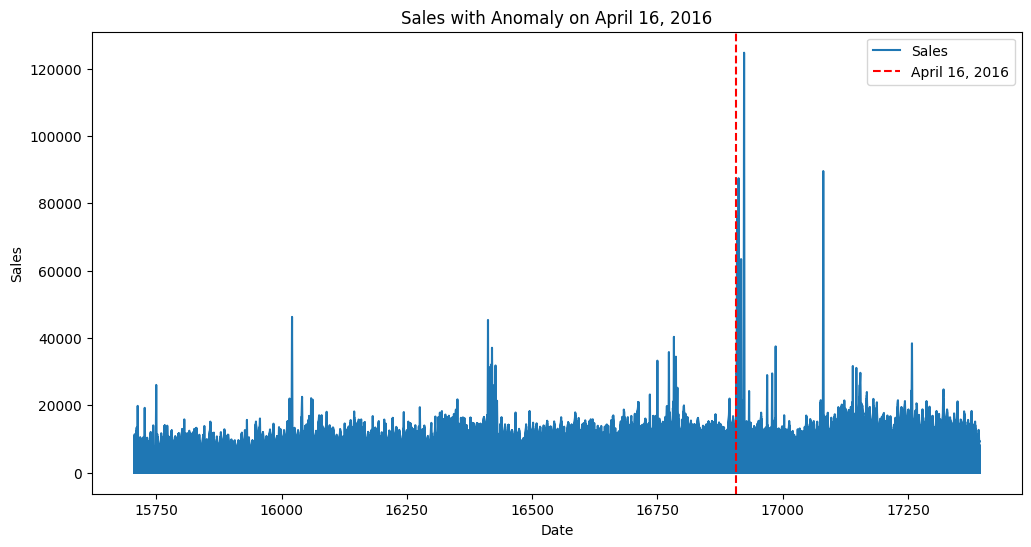

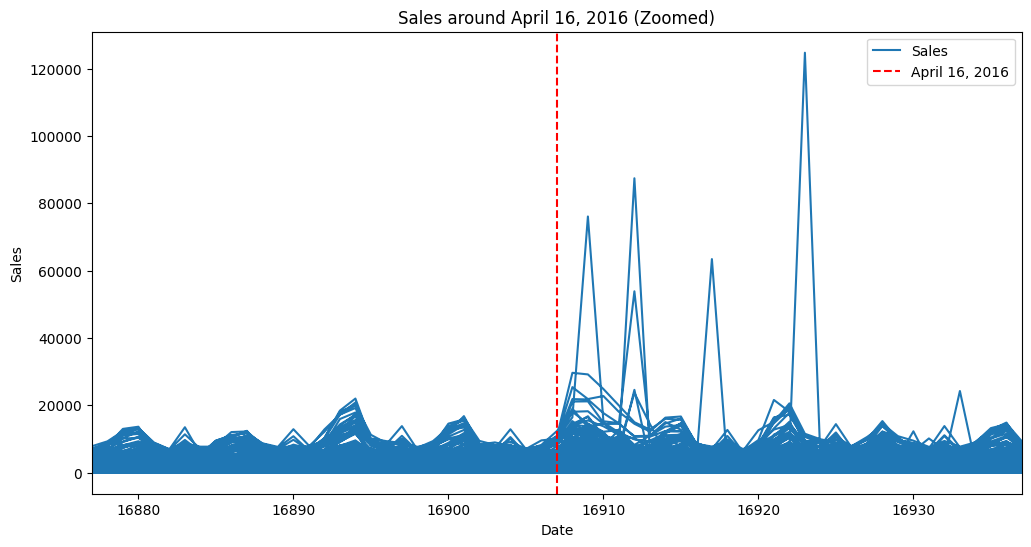

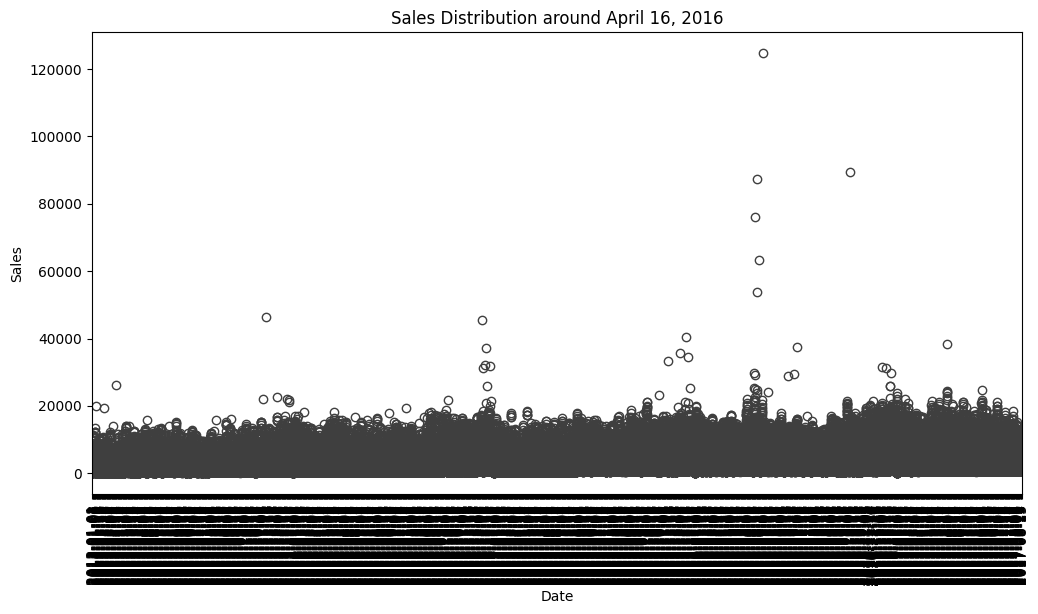

In [46]:
import matplotlib.dates as mdates  # Import the dates module

# Assuming train_processed is your DataFrame and it has a 'date' column
earthquake_date = pd.to_datetime("2016-04-16")

# Plotting sales for April 16, 2016, highlighting the anomaly
plt.figure(figsize=(12, 6))
# Convert 'date' column to matplotlib dates for plotting using mdates.date2num
dates = mdates.date2num(train_processed['date'])
plt.plot(dates, train_processed['sales'], label='Sales')
# Convert earthquake_date to a numerical value using mdates.date2num
earthquake_date_num = mdates.date2num(earthquake_date)
plt.axvline(x=earthquake_date_num, color='red', linestyle='--', label='April 16, 2016') # Use the numerical date for axvline
plt.title('Sales with Anomaly on April 16, 2016')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.show()

# You can also zoom in on the period around the earthquake to better see the anomaly:
plt.figure(figsize=(12, 6))
# Convert 'date' column to matplotlib dates for plotting using mdates.date2num
dates = mdates.date2num(train_processed['date'])
plt.plot(dates, train_processed['sales'], label='Sales')
# earthquake_date is already converted to numerical format
plt.axvline(x=earthquake_date_num, color='red', linestyle='--', label='April 16, 2016') # Use the numerical date for axvline
plt.title('Sales around April 16, 2016 (Zoomed)')
plt.xlabel('Date')
plt.ylabel('Sales')
# Convert date offsets to numerical values before using in xlim
plt.xlim(mdates.date2num(earthquake_date - pd.DateOffset(days=30)), mdates.date2num(earthquake_date + pd.DateOffset(days=30)))  # Zoom in for 30 days before and after
plt.legend()
plt.show()

# Alternatively, you can use seaborn to create a more detailed plot with a box plot to showcase distribution:
plt.figure(figsize=(12, 6))
sns.boxplot(x=train_processed['date'].dt.strftime('%Y-%m-%d'), y=train_processed['sales'])
plt.title('Sales Distribution around April 16, 2016')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.xticks(rotation=90)
plt.show()

In [47]:
# prompt:  Removing annomility of April 16, 2016 in test_processed

# Remove data points around April 16, 2016 from the training set
train_processed = train_processed[
    ~(
        (train_processed['date'] >= earthquake_date) &
        (train_processed['date'] <= earthquake_date + pd.DateOffset(weeks=4))
    )
]


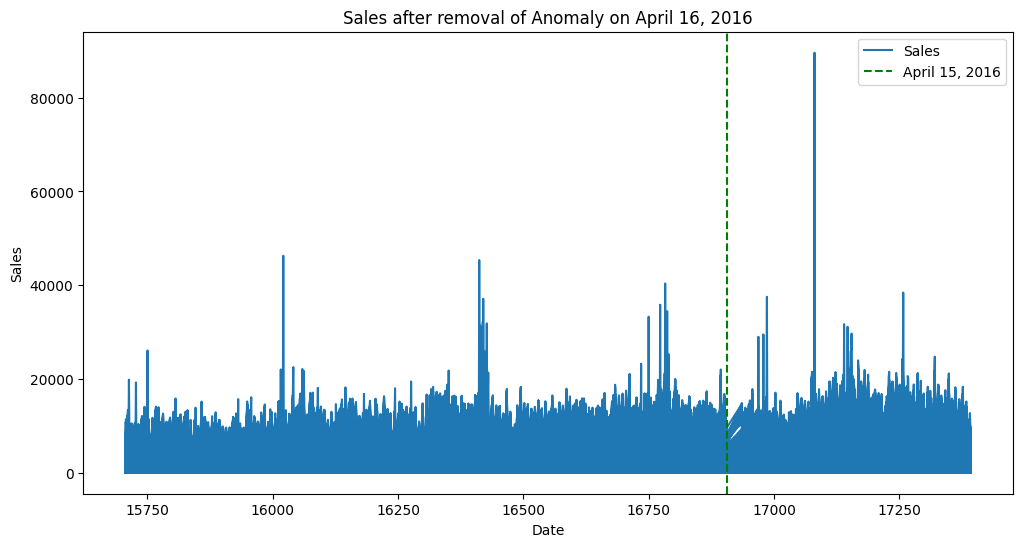

In [48]:
# Assuming train_processed is your DataFrame and it has a 'date' column
previousday_before_earthquake_date = pd.to_datetime("2016-04-15")

# Plotting sales for April 16, 2016, highlighting the anomaly
plt.figure(figsize=(12, 6))
# Convert 'date' column to matplotlib dates for plotting using mdates.date2num
dates = mdates.date2num(train_processed['date'])
plt.plot(dates, train_processed['sales'], label='Sales')
# Convert earthquake_date to a numerical value using mdates.date2num
previousday_before_earthquake_date = mdates.date2num(earthquake_date)
plt.axvline(x=previousday_before_earthquake_date, color='green', linestyle='--', label='April 15, 2016') # Use the numerical date for axvline
plt.title('Sales after removal of Anomaly on April 16, 2016')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.show()

In [49]:
train_processed.head()

,date,store_nbr,family,sales,onpromotion,dcoilwtico,Wage_day,transactions,sales_lag_1,sales_lag_7,sales_roll_mean_7,sales_roll_std_7,promo_last_7
0,2013-01-01,1,AUTOMOTIVE,0.0,0,<NA>,False,1393,0.0,0.0,0.0,0.0,0
1,2013-01-02,1,AUTOMOTIVE,2.0,0,93.14,False,2111,0.0,0.0,0.0,0.0,0
2,2013-01-03,1,AUTOMOTIVE,3.0,0,92.97,False,1833,2.0,0.0,0.0,0.0,0
3,2013-01-04,1,AUTOMOTIVE,3.0,0,93.12,False,1863,3.0,0.0,0.0,0.0,0
4,2013-01-05,1,AUTOMOTIVE,5.0,0,93.12,False,1509,3.0,0.0,0.0,0.0,0


# Feature Engineering

In [51]:
# train_processed = train_processed.to_pandas()
# test_processed = test_processed.to_pandas()

In [52]:
le = LabelEncoder()
train_processed['family'] = le.fit_transform(train_processed['family'])
test_processed['family'] = le.transform(test_processed['family'])

In [53]:
train_processed.head()

,date,store_nbr,family,sales,onpromotion,dcoilwtico,Wage_day,transactions,sales_lag_1,sales_lag_7,sales_roll_mean_7,sales_roll_std_7,promo_last_7
0,2013-01-01,1,0.0,0.0,0,NaN,False,1393,0.0,0.0,0.0,0.0,0
1,2013-01-02,1,0.0,2.0,0,93.14,False,2111,0.0,0.0,0.0,0.0,0
2,2013-01-03,1,0.0,3.0,0,92.97,False,1833,2.0,0.0,0.0,0.0,0
3,2013-01-04,1,0.0,3.0,0,93.12,False,1863,3.0,0.0,0.0,0.0,0
4,2013-01-05,1,0.0,5.0,0,93.12,False,1509,3.0,0.0,0.0,0.0,0


## List of numerical features to scale

In [54]:
# List of numerical features to scale
numerical_features = ['onpromotion', 'dcoilwtico', 'transactions', 'sales_lag_1',
                      'sales_lag_7', 'sales_roll_mean_7', 'sales_roll_std_7', 'promo_last_7']

# Initialize StandardScaler
scaler = StandardScaler()

# Fit the scaler on training data and transform training and test sets
train_processed[numerical_features] = scaler.fit_transform(train_processed[numerical_features])
test_processed[numerical_features] = scaler.transform(test_processed[numerical_features])

In [55]:
train_processed['sales_log'] = np.log1p(train_processed['sales'])

In [56]:
# Define target variable
y = train_processed['sales_log']

# Define feature set by dropping unnecessary columns
X = train_processed.drop(['date', 'sales', 'sales_log'], axis=1)

print("Defined target and feature sets.")
print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")

Defined target and feature sets.
Features shape: (2949210, 11)
Target shape: (2949210,)


In [59]:
# when using cuml
X = X.astype(np.float32)
y = y.astype(np.float32)

In [60]:
X.columns.tolist()

['store_nbr',
 'family',
 'onpromotion',
 'dcoilwtico',
 'Wage_day',
 'transactions',
 'sales_lag_1',
 'sales_lag_7',
 'sales_roll_mean_7',
 'sales_roll_std_7',
 'promo_last_7']

In [61]:
# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split( X, y, test_size=0.2, random_state=42)

print("Split data into training and validation sets.")
print(f"Training set size: {X_train.shape}")
print(f"Validation set size: {X_val.shape}")


Split data into training and validation sets.
Training set size: (2359368, 11)
Validation set size: (589842, 11)


In [62]:
# Ensure X_train and X_val are pandas DataFrames
X_train = X_train.to_pandas() if hasattr(X_train, 'to_pandas') else X_train
X_val = X_val.to_pandas() if hasattr(X_val, 'to_pandas') else X_val

# Ensure test_processed is a pandas DataFrame
test_processed = test_processed.to_pandas() if hasattr(test_processed, 'to_pandas') else test_processed


# Initialize the imputer with median strategy
imputer = SimpleImputer(strategy='median')

# Fit the imputer on training data and transform training and validation sets
X_train_imputed = pd.DataFrame(imputer.fit_transform(X_train), columns=X_train.columns, index=X_train.index)
X_val_imputed = pd.DataFrame(imputer.transform(X_val), columns=X_val.columns, index=X_val.index)

# For test_processed, ensure to drop non-feature columns before imputation
# Identify non-feature columns
non_feature_cols = ['id', 'date', 'sales', 'sales_log']

# Drop non-feature columns from test_processed if present
test_features = test_processed.drop(non_feature_cols, axis=1, errors='ignore')

# Impute the test features
test_features_imputed = pd.DataFrame(imputer.transform(test_features), columns=test_features.columns, index=test_features.index)

# Replace the imputed features back into test_processed
test_scaled = test_features_imputed.copy()

print("Handled remaining missing values using SimpleImputer.")

Handled remaining missing values using SimpleImputer.


# Model Training

## Initialize the Random Forest Regressor

In [63]:
rf = RandomForestRegressor(n_estimators=100, random_state=42) # for cuml

# rf = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)

# Fit the model on the imputed training data
rf.fit(X_train_imputed, y_train)

# Predict on the imputed validation set
y_pred_rf = rf.predict(X_val_imputed)

# Calculate evaluation metrics
rmse_rf = np.sqrt(mean_squared_error(y_val, y_pred_rf))
mae_rf = mean_absolute_error(y_val, y_pred_rf)

# Print the results
print(f"Random Forest RMSE: {rmse_rf:.4f}")
print(f"Random Forest MAE: {mae_rf:.4f}")

Random Forest RMSE: 2.4169
Random Forest MAE: 2.0799


## Initialize the XGBoost Regressor

In [64]:
xgbr = xgb.XGBRegressor(tree_method='gpu_hist',n_estimators=100, learning_rate=0.1,
                       max_depth=5, random_state=42, n_jobs=-1)

# Fit the model on the imputed training data
xgbr.fit(X_train_imputed, y_train)

# Predict on the imputed validation set
y_pred_xgbr = xgbr.predict(X_val_imputed)

# Calculate evaluation metrics
rmse_xgbr = np.sqrt(mean_squared_error(y_val, y_pred_xgbr))
mae_xgbr = mean_absolute_error(y_val, y_pred_xgbr)

# Print the results
print(f"XGBoost RMSE: {rmse_xgbr:.4f}")
print(f"XGBoost MAE: {mae_xgbr:.4f}")

XGBoost RMSE: 2.2493
XGBoost MAE: 1.8860


## Model Evaulation

In [65]:
evaluation_df = pd.DataFrame({
    'Model': ['Random Forest', 'XGBoost'],
    'RMSE': [rmse_rf, rmse_xgbr],
    'MAE': [mae_rf, mae_xgbr]
})

# Display the evaluation results
print(evaluation_df)

           Model      RMSE       MAE
0  Random Forest  2.416885  2.079948
1        XGBoost  2.249341  1.886034


## Initialize the best model

In [66]:
final_model = xgb.XGBRegressor(tree_method='gpu_hist', n_estimators=100, learning_rate=0.1,
                              max_depth=5, random_state=42, n_jobs=-1)

# Define the full training data
final_X = X_train_imputed
final_y = y_train

# Fit the final model on the entire training data
final_model.fit(final_X, final_y)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=-1,
             num_parallel_tree=None, random_state=42, ...)

In [67]:
test_features = test_scaled.copy()
test_features.columns.tolist()

['store_nbr',
 'family',
 'onpromotion',
 'dcoilwtico',
 'Wage_day',
 'transactions',
 'sales_lag_1',
 'sales_lag_7',
 'sales_roll_mean_7',
 'sales_roll_std_7',
 'promo_last_7']

In [68]:
# Make predictions on the test set
test_pred_log = final_model.predict(test_features)

# Inverse the log transformation
test_pred = np.expm1(test_pred_log)

# Ensure no negative sales predictions
test_pred = np.where(test_pred < 0, 0, test_pred)

In [69]:
test_pred

array([ 5.401081,  5.401081,  5.401081, ..., 11.09746 , 11.09746 ,
       11.431003], dtype=float32)

In [70]:
df_train.tail()

,date,store_nbr,family,sales,onpromotion,dcoilwtico,is_train
3000883,2017-08-15,9,POULTRY,438.133,0,47.57,1
3000884,2017-08-15,9,PREPARED FOODS,154.553,1,47.57,1
3000885,2017-08-15,9,PRODUCE,2419.729,148,47.57,1
3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.000,8,47.57,1
3000887,2017-08-15,9,SEAFOOD,16.000,0,47.57,1


In [71]:
df_test.head()

,date,store_nbr,family,onpromotion,dcoilwtico,is_train,sales
0,2017-08-16,1,AUTOMOTIVE,0,46.8,0,NaN
1,2017-08-16,1,BABY CARE,0,46.8,0,NaN
2,2017-08-16,1,BEAUTY,2,46.8,0,NaN
3,2017-08-16,1,BEVERAGES,20,46.8,0,NaN
4,2017-08-16,1,BOOKS,0,46.8,0,NaN


In [72]:
df_test = pd.read_csv('test.csv', parse_dates=['date'], index_col='id')

In [73]:
submission = pd.DataFrame({
    'id': df_test.index,
    'sales': test_pred
})

In [74]:
submission.head()

,id,sales
0,3000888,5.401081
1,3000889,5.401081
2,3000890,5.401081
3,3000891,5.401081
4,3000892,5.401081


In [ ]:
# submission.to_csv('submission.csv', index=False)

In [ ]:
# import locale
# def getpreferredencoding(do_setlocale = True):
#     return "UTF-8"
# locale.getpreferredencoding = getpreferredencoding
# !kaggle competitions submit -c store-sales-time-series-forecasting -f submission.csv -m "My XGBoost submission"

In [80]:
merged_df = combined.copy()

In [81]:
cols_to_drop = ["sales_lag_1", "sales_lag_7", "sales_roll_mean_7", "sales_roll_std_7", "promo_last_7"]
merged_df = merged_df.drop(columns=cols_to_drop, errors='ignore')

In [82]:
merged_df.head()

,date,store_nbr,family,sales,onpromotion,dcoilwtico,is_train,Wage_day,transactions
0,2013-01-01,1,AUTOMOTIVE,0.0,0,<NA>,1,False,1393
1,2013-01-02,1,AUTOMOTIVE,2.0,0,93.14,1,False,2111
2,2013-01-03,1,AUTOMOTIVE,3.0,0,92.97,1,False,1833
3,2013-01-04,1,AUTOMOTIVE,3.0,0,93.12,1,False,1863
4,2013-01-05,1,AUTOMOTIVE,5.0,0,93.12,1,False,1509


In [84]:
#remove anaomility
merged_df = merged_df[
    ~(
        (merged_df['date'] >= earthquake_date) &
        (merged_df['date'] <= earthquake_date + pd.DateOffset(weeks=4))
    )
]

In [87]:
merged_df['dcoilwtico'].fillna(method='bfill', inplace=True)

In [88]:
merged_df.isnull().sum()

,0
date,0
store_nbr,0
family,0
sales,28512
onpromotion,0
dcoilwtico,0
is_train,0
Wage_day,0
transactions,0


In [89]:
merged_df.to_csv('merged_df.csv', index=False)
from google.colab import files
files.download('merged_df.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>